# Homework 04

## Group 10

This week we are using our learned power for good and create a neural network for automatic malaria detection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

Let's first load our dataset and take a brief look at it using the built-in `show_examples()` method of the tensorflow datasets. The data only comes with a predefined training split. To get testing data to measure the performance of our model, we split the training set up. To make adjusting the split a little easier, we'll give you a parameter for this. Just choose how many percent of the data you want to use for training.

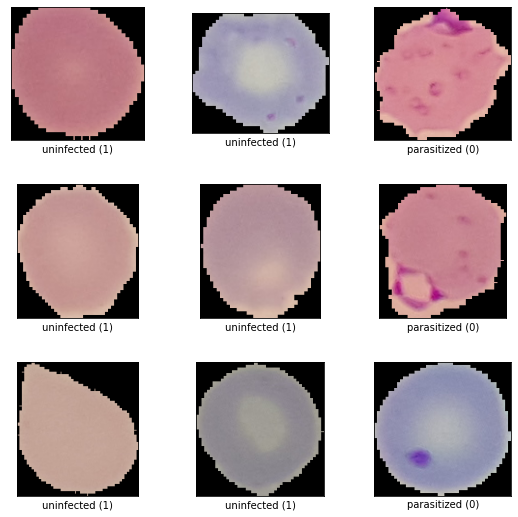

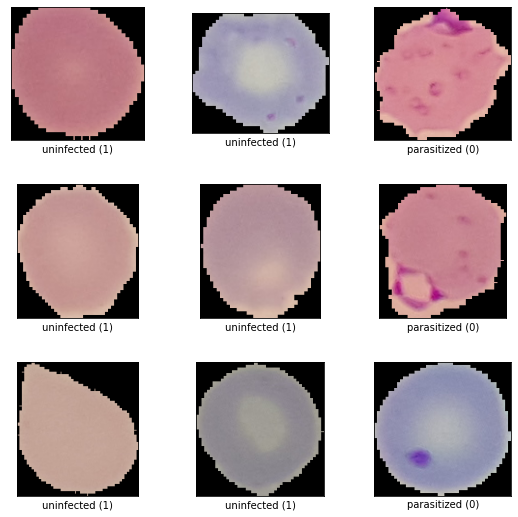

In [2]:
split_size = "80%"
(train_data, test_data), info = tfds.load(
    "malaria",
    split=[f"train[:{split_size}]", f"train[{split_size}:]"],
    as_supervised=True,
    with_info=True
    )

tfds.show_examples(train_data, info)

How is our data structured? First we are going to look at how many classes we have, and how many samples are in the training and testing set after the split.

In [3]:
print(f"Classes: {info.features['label'].names}")

print(f"Training set size: {tf.data.experimental.cardinality(train_data)}")
print(f"Testing set size: {tf.data.experimental.cardinality(test_data)}")

Classes: ['parasitized', 'uninfected']
Training set size: 22046
Testing set size: 5512


In [4]:
for image, _ in train_data.take(5):
    print("Image shape: ", image.numpy().shape)

Image shape:  (103, 103, 3)
Image shape:  (106, 121, 3)
Image shape:  (139, 142, 3)
Image shape:  (130, 118, 3)
Image shape:  (121, 109, 3)


Our images are not equally sized. Luckily tensorflow gives an Image API which allows us to resize the image. Note that there is also an `image.resize()` function, but using it will result in distortion if the images aspect ratio does not match the target ration, square in our case. So we will use `resize_with_pad()` instead.

In [5]:
test_data = test_data.map(lambda img, label: (tf.image.resize_with_pad(img, 128, 128)/255, tf.one_hot(label,1)))
train_data = train_data.map(lambda img, label: (tf.image.resize_with_pad(img, 128, 128)/255, tf.one_hot(label,1)))

A lot is happening in the cell above, so let's break it down:

1. With `map` we apply the following operation to every single element in the set.
2. Resize the image to 128x128 pixels by either cropping or padding the image. The decision is made by tensorflow. We also devide by 255 to normalize the images, meaning the resulting values will all be between 0 and 1.
3. Onehotify our label.

Verify that it worked by printing some examples.

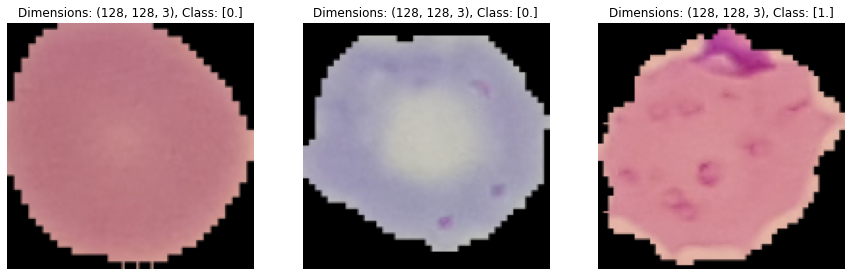

In [6]:
fig, axis = plt.subplots(ncols = 3, figsize=(15, 15))

for i, (image, label) in enumerate(train_data.take(3)):
    axis[i].imshow(image)
    axis[i].axis("off") # Do not display any axis label
    axis[i].set_title(f"Dimensions: {image.numpy().shape}, Class: {label.numpy()}")
plt.show()


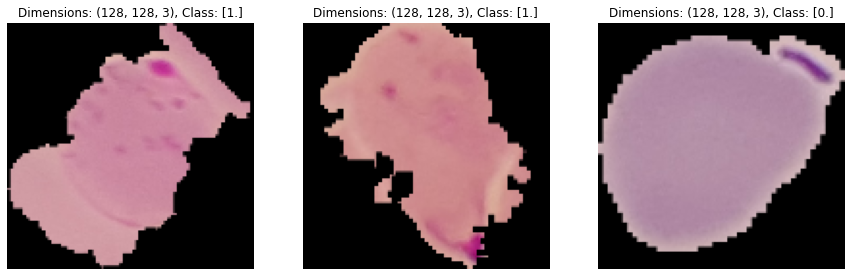

In [7]:
fig, axis = plt.subplots(ncols = 3, figsize=(15, 15))

for i, (image, label) in enumerate(test_data.take(3)):
    axis[i].imshow(image)
    axis[i].axis("off") # Do not display any axis label
    axis[i].set_title(f"Dimensions: {image.numpy().shape}, Class: {label.numpy()}")
plt.show()


Now a little experiment. We know that each pixel is represented with 3 Colors (Red, Green, Blue). In the following we will convert the images into grayscale to only work with one value. In this way the cell coloring is not important anymore but rather the contrast which shows infected areas.

In [8]:
train_data_bw = train_data.map(lambda img, label: (tf.image.rgb_to_grayscale(img), label))
test_data_bw = test_data.map(lambda img, label: (tf.image.rgb_to_grayscale(img), label))

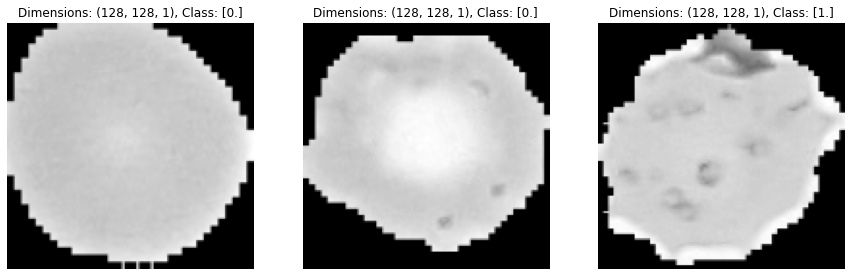

In [9]:
fig, axis = plt.subplots(ncols = 3, figsize=(15, 15))

for i, (image, label) in enumerate(train_data_bw.take(3)):
    axis[i].imshow(image, cmap="gray") # Otherwise matplotlib will apply its default colorscheme
    axis[i].axis("off") # Do not display any axis label
    axis[i].set_title(f"Dimensions: {image.numpy().shape}, Class: {label.numpy()}")
plt.show()

In [10]:
# Prepare the data
batch_size = 128
prefetch_size = 128

train_data = train_data.shuffle(buffer_size=batch_size)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=prefetch_size)

test_data = test_data.shuffle(buffer_size=batch_size)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=prefetch_size)

# And the same for our grayscale set

train_data_bw = train_data_bw.shuffle(buffer_size=batch_size)
train_data_bw = train_data_bw.batch(batch_size)
train_data_bw = train_data_bw.prefetch(buffer_size=prefetch_size)

test_data_bw = test_data_bw.shuffle(buffer_size=batch_size)
test_data_bw = test_data_bw.batch(batch_size)
test_data_bw = test_data_bw.prefetch(buffer_size=prefetch_size)

In [11]:
class Model(tf.keras.Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                             input_shape = (128,128,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        self.conv_3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        self.conv_4 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)
                                               
       
    def call(self, x):
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.global_pool(x)
        return self.output_layer(x)

In [12]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.mean(abs(target - prediction) < 0.5)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [13]:
%%time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 50
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_data, binary_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_data, binary_cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_data.shuffle(buffer_size=128)
    test_dataset = test_data.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:
        train_loss = train_step(model, input, target, binary_cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_data, binary_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
Epoch: __ 30
Epoch: __ 31
Epoch: __ 32
Epoch: __ 33
Epoch: __ 34
Epoch: __ 35
Epoch: __ 36
Epoch: __ 37
Epoch: __ 38
Epoch: __ 39
Epoch: __ 40
Epoch: __ 41
Epoch: __ 42
Epoch: __ 43
Epoch: __ 44
Epoch: __ 45
Epoch: __ 46
Epoch: __ 47
Epoch: __ 48
Epoch: __ 49
CPU times: user 1h 7min 58s, sys: 4min 31s, total: 1h 12min 30s
Wall time: 37min 42s


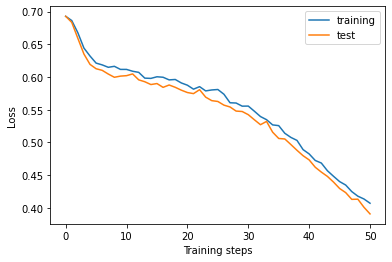

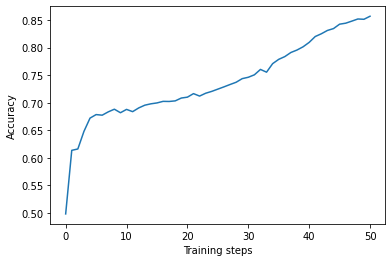

In [14]:

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

After training for 50 epochs we get >85% accuracy which we might be able to improve even further with more training.

## Saving our model

Since our training this week took quite some time, we want to save the complete model for later use.

In [16]:
model.save_weights("malaria_model.h5")

# Training on the grayscale input

In [18]:
%%time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_data_bw, binary_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_data_bw, binary_cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_data_bw.shuffle(buffer_size=128)
    test_dataset = test_data_bw.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data_bw:
        train_loss = train_step(model, input, target, binary_cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_data_bw, binary_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
CPU times: user 38min 59s, sys: 2min 27s, total: 41min 26s
Wall time: 21min 31s


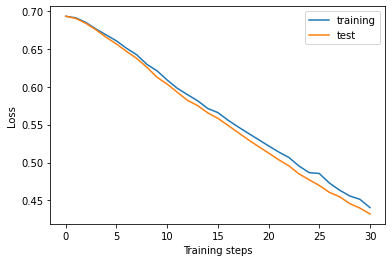

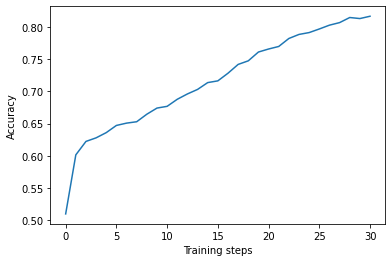

In [19]:

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

We see that we reach similar results with the grayscale images, but there is no really substantial difference in this case why we want to choose one over another. 

# Bonus: Tensorflow with GPU Acceleration

Once we start to dip into more complex models, like we did this week, the training times begin to add up. Now even training for just a few epochs, can take half an hour or longer. So I decided to take a look at how to run the models on my graphics card (or GPU = Graphical Processing Unit) which promises substantial reduction of training time.
## Requirements
Sadly you cannot get this performance increase on every machine. You'll need an NVIDIA GPU which supports [CUDA](https://developer.nvidia.com/cuda-zone) and be running Windows or Linux, so no GPU accelerated tensorflow for Mac Users. Of course there other ways to improve tensorflow performance on a Mac, especially with the new M1 chip coming out. An interesting article by tensorflow themselves can be found [here](https://blog.tensorflow.org/2020/11/accelerating-tensorflow-performance-on-mac.html)

For installation, I referred to the [official guide](https://www.tensorflow.org/install/gpu). I tried to install on my system (running [Manjaro](https://manjaro.org/) Linux), but with the conda environment, local Python install and package requirements of the tensorflow CUDA support I could not get it to work.

## Solution for me: Docker
As they mention in the guide I linked above, the "easiest" way to enjoy tensorflow with GPU on Linux is to use their [docker](https://www.docker.com/) image.
I have never used docker before, so down we go this rabbit hole. Docker works with so-called containers which run isolated from your local machine, but still can utilize the hardware like the GPU or Internet connection. The [tensorflow docker guide](https://www.tensorflow.org/install/docker) is pretty good, and I was able to run my container with tensorflow, gpu support and a jupyter notebook integration.

An initial test showed that my models trained about **8x** faster on my GPU. That really made the process much more fun.

**Note:** The official tensorflow image uses Python 3.6.9 as default Python installation, not 3.7 as recommended in this course's setup. However, since we haven't used 3.7 specific stuff so far, you should be just fine with it.

## Integration with VSCode
I use Visual Studio Code as my main text editor for nearly all development purposes and also for working with jupyter notebooks (I love to use Intellij when writing the code).

The [Remote-Container](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-containers) extension allows me to run the tensorflow container right in my development environment by using a Dockerfile and a .devcontainer. For reference I uploaded the configuration files I use to [Github](https://github.com/Maxoz99/ANNs-TensorFlow/tree/max). Now I just have to click "open in container" and everything is setup and ready to go.

If you enjoyed this little bonus or think this should be fleshed out into a more detailed guide for other students feel free to drop us a message.
